In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import time
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

from sklearn.neural_network import MLPClassifier

In [5]:
import mysql_connector_ssh_rsa

In [6]:
Con = mysql_connector_ssh_rsa.Connector

In [21]:
query = 'select * from `es-orders`.orders'
df = Con.mysql_connect(query)

In [29]:
df_filter = df[(df.status_id == 'DELETE') | (df.status_id == 'DONE')]
# df_filter = df[(df.status_id == 'DONE')]
# df_filter = df_filter[df.distance > 1500]

In [30]:
df_filter.head()

,id,user_id,client_name,client_phone_number,date,cargo_count,passengers_count,notes,total,additional_hour_price,...,driver_percent,crew_id,date_start,date_end,paid_by_cash,discount,tariff_param_id,duration_by_order_points,crew_assigned_at,fact_duration
4,8,2.0,Pere Vera,+34637895736,2022-04-03 11:00:23,1,1,realizado 31/03/2022 bizum,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
5,9,2.0,Raul Castro,+34603644103,2022-04-01 08:29:26,1,1,Carga varios televisores\n80 €,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
6,10,2.0,Pera,+34637895736,2022-04-30 17:44:48,1,1,"RECOGIDA , CARGA , TRANSPORTE DE UN MUEBLE Y U...",80.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
10,14,4.0,SILVIA,+34674744337,2022-04-04 15:00:17,0,0,"Cajas , 1 bicicleta y algunas cosas mas\n100€",100.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
11,15,5.0,Walter Ariel GUERREIRO,+34643284031,2022-04-29 15:05:39,1,1,Pide cliente servicio de desmontar,87.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0


In [23]:
df_date = df_filter
df_date.status_id = df_filter.status_id.map({'DONE': 1, 'DELETE': 0})

In [98]:
df_date = df_date[df_date.date < '2022-11-07 14:00:00']
df_date = df_date[df_date.status_id == 1]
df_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272 entries, 4 to 4481
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1272 non-null   int64         
 1   user_id                   1181 non-null   float64       
 2   client_name               1272 non-null   object        
 3   client_phone_number       1272 non-null   object        
 4   date                      1272 non-null   datetime64[ns]
 5   cargo_count               1272 non-null   int64         
 6   passengers_count          1272 non-null   int64         
 7   notes                     1255 non-null   object        
 8   total                     1272 non-null   float64       
 9   additional_hour_price     1272 non-null   float64       
 10  driver_name               326 non-null    object        
 11  created_at                1272 non-null   datetime64[ns]
 12  updated_at          

In [12]:
print(type(df_date.loc[5]['date']))
print(df_date.loc[5]['date'].date())

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2022-04-01


In [13]:
df_date['date'] = df_date['date'].dt.date

In [14]:
# df_date['count'] = sm.add_constant(1)
df_date.head()

,id,user_id,client_name,client_phone_number,date,cargo_count,passengers_count,notes,total,additional_hour_price,...,driver_percent,crew_id,date_start,date_end,paid_by_cash,discount,tariff_param_id,duration_by_order_points,crew_assigned_at,fact_duration
4,8,2.0,Pere Vera,+34637895736,2022-04-03,1,1,realizado 31/03/2022 bizum,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
5,9,2.0,Raul Castro,+34603644103,2022-04-01,1,1,Carga varios televisores\n80 €,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
6,10,2.0,Pera,+34637895736,2022-04-30,1,1,"RECOGIDA , CARGA , TRANSPORTE DE UN MUEBLE Y U...",80.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
10,14,4.0,SILVIA,+34674744337,2022-04-04,0,0,"Cajas , 1 bicicleta y algunas cosas mas\n100€",100.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
11,15,5.0,Walter Ariel GUERREIRO,+34643284031,2022-04-29,1,1,Pide cliente servicio de desmontar,87.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0


In [15]:
df_date1 = df_date.groupby('date')['count'].count()
df_date1

KeyError: 'Column not found: count'

In [16]:
df_date1.plot(kind='line', x='date', y='count')

NameError: name 'df_date1' is not defined

In [827]:
# df_filter = df_filter[df.cargo_count < 3]

In [17]:
df_filter.groupby('is_individual_calc')['status_id'].count()

is_individual_calc
0    337
1    958
Name: status_id, dtype: int64

In [31]:
# df_research = df_filter[['status_id', 'total', 'distance', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'source_id', 'payment_method']]
df_research = df_filter[['status_id', 'total', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration', 'distance_out_of_city', 'paid_by_cash', 'discount', 'tariff_param_id']]

# df_research = df_filter[['status_id', 'total', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'source_id', 'communication_method', 'payment_method', 'duration', 'distance_out_of_city', 'driver_percent', 'paid_by_cash', 'discount', 'tariff_param_id']]

In [32]:
df_research.status_id = df_research.status_id.map({'DONE': 1, 'DELETE': 0})

In [33]:
df_research.status_id.unique()

array([1, 0])

In [34]:
df_dummy = pd.get_dummies(df_research, columns=['cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration',  'tariff_param_id', 'discount'], drop_first=True)
# df_dummy = pd.get_dummies(df_research, columns=['cargo_count', 'is_individual_calc', 'source_id', 'communication_method', 'payment_method',  'duration', 'driver_percent', 'discount', 'tariff_param_id'], drop_first=True)

In [35]:
numeric_cols = ['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash' ]
cat_cols = list(set(df_dummy.columns) - set(numeric_cols) - {'status_id'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash']
['cargo_count_1', 'cargo_count_2', 'cargo_count_3', 'cargo_count_4', 'cargo_count_5', 'communication_method_phone', 'communication_method_whatsapp', 'discount_1', 'discount_10', 'discount_2', 'discount_3', 'discount_4', 'discount_5', 'discount_6', 'discount_7', 'discount_8', 'discount_9', 'duration_1.0', 'duration_10.0', 'duration_11.0', 'duration_12.0', 'duration_2.0', 'duration_3.0', 'duration_4.0', 'duration_5.0', 'duration_6.0', 'duration_7.0', 'duration_8.0', 'duration_9.0', 'is_individual_calc_1', 'payment_method_card', 'payment_method_cash', 'payment_method_terminal', 'tariff_param_id_10.0', 'tariff_param_id_15.0', 'tariff_param_id_17.0', 'tariff_param_id_2.0', 'tariff_param_id_4.0', 'tariff_param_id_7.0', 'tariff_param_id_8.0', 'tariff_param_id_9.0']


In [139]:
random_seed = np.random.seed(0)
df_train, df_test = train_test_split(df_dummy, test_size=0.25, random_state=random_seed, stratify=df_dummy['status_id'])
# df_train, df_test = df_dummy, df_dummy

print(df_dummy.shape)
print(df_train.shape)
print(df_test.shape)
print()
print(df_dummy['status_id'].value_counts(normalize=True))
print()
print(df_train['status_id'].value_counts(normalize=True))
print()
print(df_test['status_id'].value_counts(normalize=True))

(3985, 47)
(2988, 47)
(997, 47)

0    0.665747
1    0.334253
Name: status_id, dtype: float64

0    0.665663
1    0.334337
Name: status_id, dtype: float64

0    0.665998
1    0.334002
Name: status_id, dtype: float64


In [127]:
# Преобразуем возраст в скалярную величину
scaler = StandardScaler()
scaler.fit(df_dummy[numeric_cols])

StandardScaler()

In [128]:
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['status_id']
    return X, y

X_train, y_train = get_features_and_target_arrays(df_dummy, numeric_cols, cat_cols, scaler)

In [39]:
clf = LogisticRegression(penalty='none')
clf.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [129]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

In [166]:
clf_tree = DecisionTreeClassifier()

In [167]:
clf_forest = RandomForestClassifier()

In [168]:
params_tree = {'criterion':['gini', 'entropy'], 'max_depth': range(1, 10), 'min_samples_split': range(0, 50, 10), 'min_samples_leaf': range(0,100, 10)}

In [169]:
params_forest = {'n_estimators': range(3, 30, 5), 'criterion':['gini', 'entropy'], 'max_depth': range(1, 10), 'min_samples_split': range(0, 100, 10), 'min_samples_leaf': range(0, 50, 10)}

In [170]:
grid_search_cv_clf=GridSearchCV(clf_tree, params_tree, cv=5)

In [171]:
grid_search_cv_clf_rf = GridSearchCV(clf_forest, params_forest, cv=5)

In [172]:
grid_search_cv_clf.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(0, 100, 10),
                         'min_samples_split': range(0, 50, 10)})

In [173]:
grid_search_cv_clf_rf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(0, 50, 10),
                         'min_samples_split': range(0, 100, 10),
                         'n_estimators': range(3, 30, 5)})

In [181]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=60,
                       min_samples_split=10)

In [182]:
best_clf_rf = grid_search_cv_clf_rf.best_estimator_

In [183]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 60,
 'min_samples_split': 10}

In [184]:
best_clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=60,
                       min_samples_split=10)

In [185]:
best_clf_rf.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=20,
                       min_samples_split=10, n_estimators=28)

In [130]:
clf_nn = MLPClassifier(activation='relu', hidden_layer_sizes=(10, 10, 10, 10, 10, 10), max_iter=5000)

In [78]:
params_nn = {'hidden_layer_sizes': (10, 10, 10),  'max_iter': range(1000, 10000, 1000), 'activation': ['identity', 'logistic', 'tanh', 'relu']}

In [79]:
grid_search_cv_clf_nn = GridSearchCV(clf_nn, params_nn, cv=5)

In [80]:
grid_search_cv_clf_nn.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': (10, 10, 10),
                         'max_iter': range(1000, 10000, 1000)})

In [81]:
best_clf_nn = grid_search_cv_clf_nn.best_estimator_
best_clf_nn

MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=1000)

In [131]:
best_clf_nn = clf_nn.fit(X_train, y_train)

In [132]:
best_clf_nn.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10, 10, 10), max_iter=5000)

In [133]:
predictions = best_clf_nn.predict(X_test)

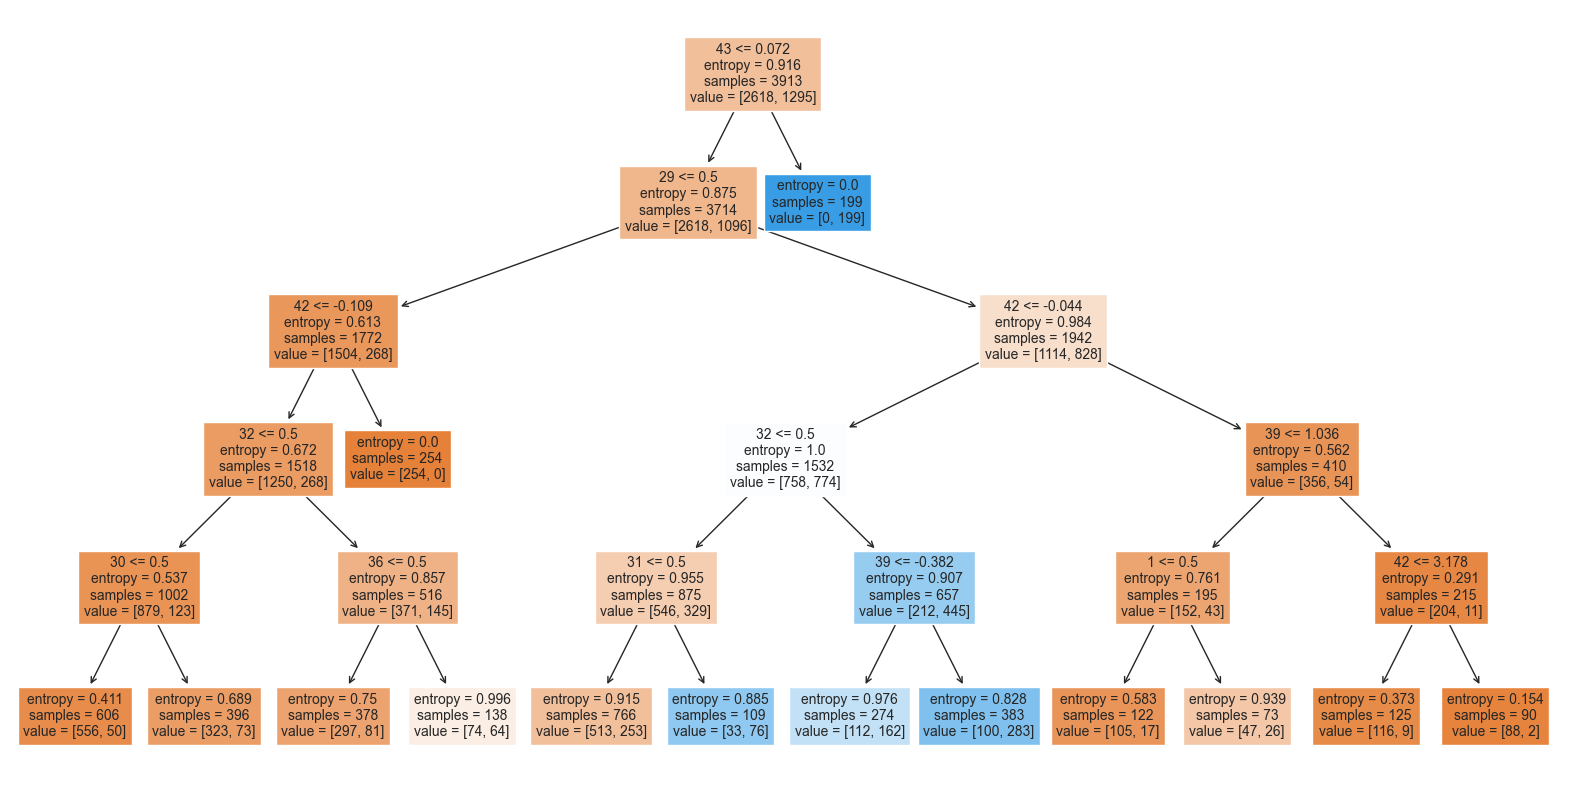

In [117]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, fontsize=10, feature_names=list(X), filled=True)
plt.show()

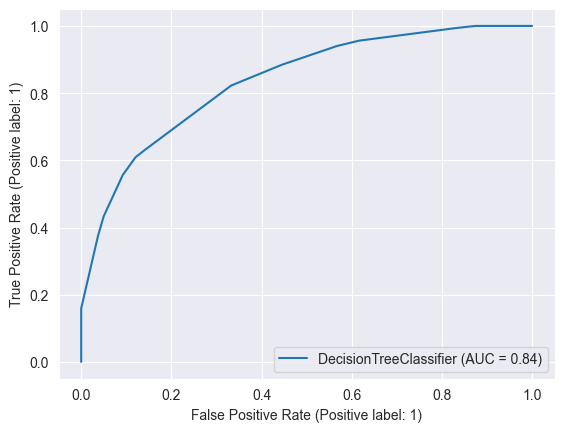

In [187]:
plot_roc_curve(best_clf, X_test, y_test)
plt.show()

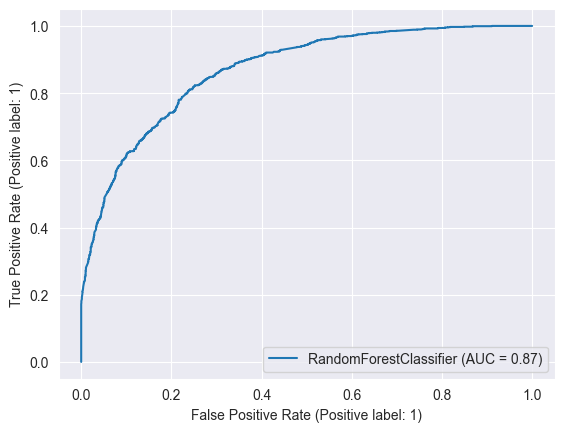

In [188]:
plot_roc_curve(best_clf_rf, X_test, y_test)
plt.show()

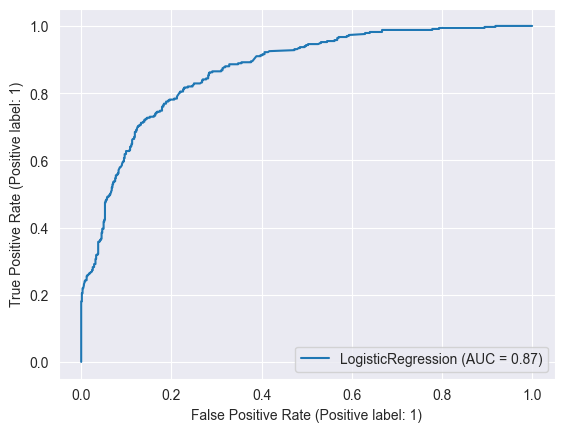

In [41]:
plot_roc_curve(clf, X_test, y_test)
plt.show()

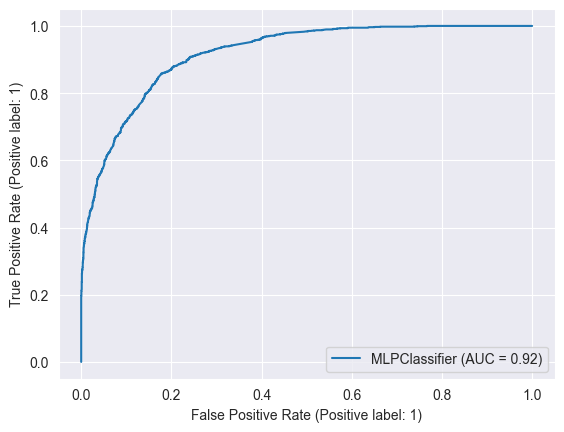

In [134]:
plot_roc_curve(best_clf_nn, X_test, y_test)
plt.show()

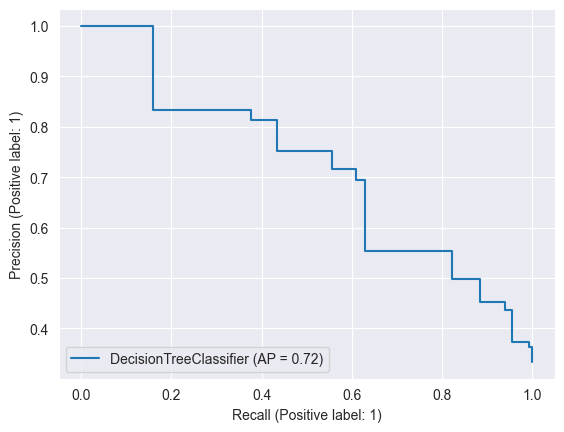

In [190]:
plot_precision_recall_curve(best_clf, X_test, y_test)
plt.show()

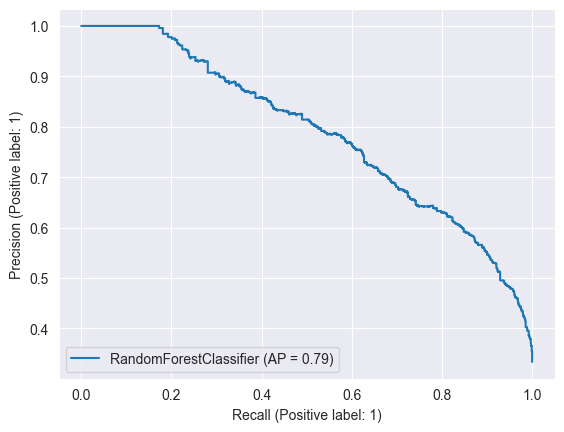

In [191]:
plot_precision_recall_curve(best_clf_rf, X_test, y_test)
plt.show()

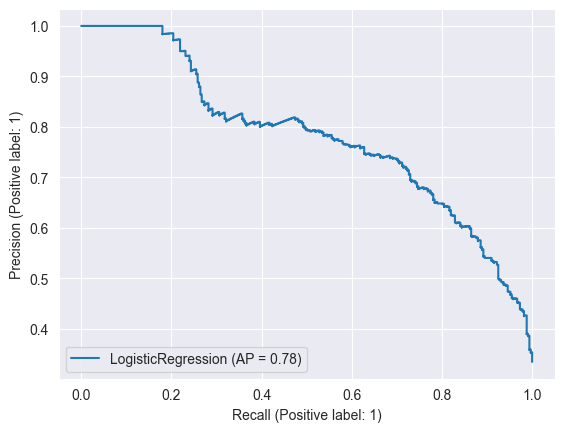

In [42]:
plot_precision_recall_curve(clf, X_test, y_test)
plt.show()

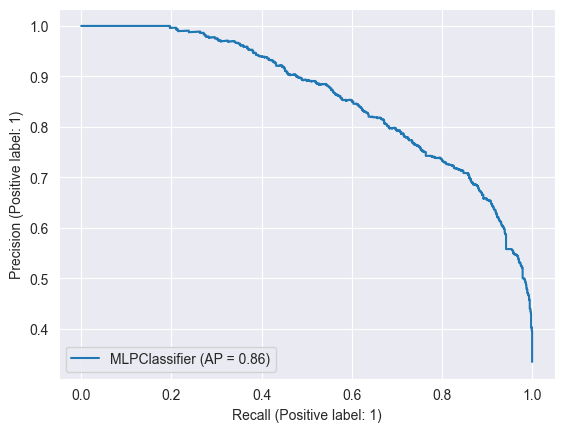

In [135]:
plot_precision_recall_curve(best_clf_nn, X_test, y_test)
plt.show()

In [43]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [194]:
test_prob_tree = best_clf.predict_proba(X_test)[:, 1]
test_pred_tree = best_clf.predict(X_test)

In [195]:
test_prob_forest = best_clf_rf.predict_proba(X_test)[:, 1]
test_pred_forest = best_clf_rf.predict(X_test)

In [136]:
test_prob_mlp = best_clf_nn.predict_proba(X_test)[:, 1]
test_pred_mlp = best_clf_nn.predict(X_test)

In [140]:
test_prob_mlp

array([1.74890002e-01, 2.18254362e-01, 6.01097735e-01, ...,
       3.70092242e-06, 6.65119482e-08, 9.99670000e-01])

In [141]:
test_pred_mlp

array([0, 0, 1, ..., 0, 0, 1])

In [196]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob_tree)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob_tree)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob_tree)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred_tree)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred_tree)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred_tree)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred_tree)))

print('\nClassification Report')
print(classification_report(y_test, test_pred_tree))

Log loss = 0.44427
AUC = 0.83657
Average Precision = 0.71712

Using 0.5 as threshold:
Accuracy = 0.79059
Precision = 0.75127
Recall = 0.55623
F1 score = 0.63920

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2648
           1       0.75      0.56      0.64      1325

    accuracy                           0.79      3973
   macro avg       0.78      0.73      0.75      3973
weighted avg       0.79      0.79      0.78      3973



In [197]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob_forest)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob_forest)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob_forest)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred_forest)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred_forest)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred_forest)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred_forest)))

print('\nClassification Report')
print(classification_report(y_test, test_pred_forest))

Log loss = 0.45117
AUC = 0.86863
Average Precision = 0.78799

Using 0.5 as threshold:
Accuracy = 0.79638
Precision = 0.80569
Recall = 0.51321
F1 score = 0.62702

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2648
           1       0.81      0.51      0.63      1325

    accuracy                           0.80      3973
   macro avg       0.80      0.73      0.74      3973
weighted avg       0.80      0.80      0.78      3973



In [44]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.41226
AUC = 0.86935
Average Precision = 0.78135

Using 0.5 as threshold:
Accuracy = 0.81545
Precision = 0.72923
Recall = 0.71171
F1 score = 0.72036

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       664
           1       0.73      0.71      0.72       333

    accuracy                           0.82       997
   macro avg       0.79      0.79      0.79       997
weighted avg       0.81      0.82      0.81       997



In [137]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob_mlp)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob_mlp)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob_mlp)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred_mlp)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred_mlp)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred_mlp)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred_mlp)))

print('\nClassification Report')
print(classification_report(y_test, test_pred_mlp))

Log loss = 0.33467
AUC = 0.91757
Average Precision = 0.85843

Using 0.5 as threshold:
Accuracy = 0.83789
Precision = 0.76923
Recall = 0.73574
F1 score = 0.75211

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2653
           1       0.77      0.74      0.75      1332

    accuracy                           0.84      3985
   macro avg       0.82      0.81      0.82      3985
weighted avg       0.84      0.84      0.84      3985



Confusion Matrix


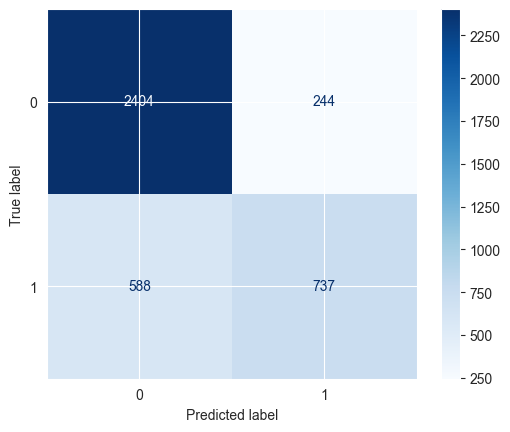

[[2404  244]
 [ 588  737]]
<class 'numpy.ndarray'>


In [199]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred_tree)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

Confusion Matrix


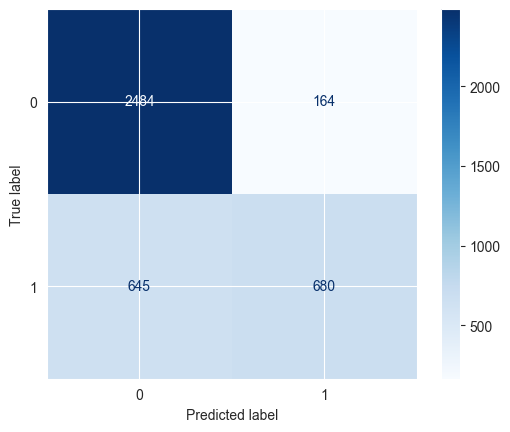

[[2484  164]
 [ 645  680]]
<class 'numpy.ndarray'>


In [200]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred_forest)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

Confusion Matrix


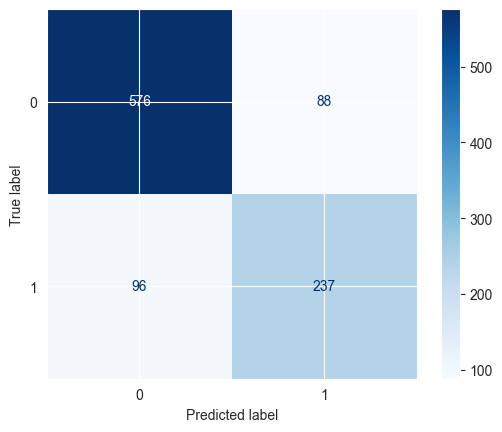

[[576  88]
 [ 96 237]]
<class 'numpy.ndarray'>


In [45]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

Confusion Matrix


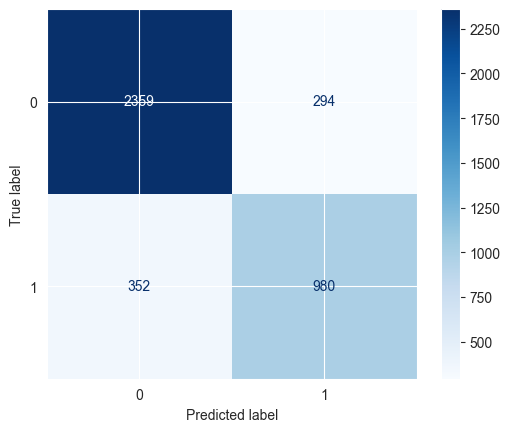

[[2359  294]
 [ 352  980]]
<class 'numpy.ndarray'>


In [138]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred_mlp)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

In [858]:
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

,variable,coefficient
0,intercept,-3.346211
1,cargo_count_1,0.839665
2,cargo_count_2,0.674202
3,cargo_count_3,0.578334
4,cargo_count_4,-0.075777
5,communication_method_phone,-0.753986
6,communication_method_whatsapp,-1.096975
7,discount_1,-2.531203
8,discount_10,0.480745
9,discount_2,0.176707


In [859]:
df_dummy['status_id'].value_counts()

0    2498
1    1236
Name: status_id, dtype: int64

In [860]:
x_result = pd.DataFrame()
x_result['fact'] = df_dummy['status_id']
x_result['predict'] = test_pred
x_result['result'] = x_result.fact - x_result.predict
x_result = x_result['result'].value_counts()
x_result.index = ['Match', 'False-Negative', 'False-Positive']
x_result = pd.concat([x_result, x_result / sum(x_result)], axis=1)
x_result

,result,result
Match,2994,0.801821
False-Negative,404,0.108195
False-Positive,336,0.089984


In [231]:
feature_importance = best_clf_rf.feature_importances_

In [232]:
features_names = cat_cols + numeric_cols
features_names

['cargo_count_1',
 'cargo_count_2',
 'cargo_count_3',
 'cargo_count_4',
 'cargo_count_5',
 'communication_method_phone',
 'communication_method_whatsapp',
 'discount_1',
 'discount_10',
 'discount_2',
 'discount_3',
 'discount_4',
 'discount_5',
 'discount_6',
 'discount_7',
 'discount_8',
 'discount_9',
 'duration_1.0',
 'duration_10.0',
 'duration_11.0',
 'duration_12.0',
 'duration_2.0',
 'duration_3.0',
 'duration_4.0',
 'duration_5.0',
 'duration_6.0',
 'duration_7.0',
 'duration_8.0',
 'duration_9.0',
 'is_individual_calc_1',
 'payment_method_card',
 'payment_method_cash',
 'payment_method_terminal',
 'source_id_EMAIL',
 'source_id_FACEBOOK',
 'source_id_INCOMING_CALL',
 'source_id_SITE',
 'source_id_SITE_CHAT',
 'source_id_WHATSAPP',
 'tariff_param_id_10.0',
 'tariff_param_id_2.0',
 'tariff_param_id_4.0',
 'tariff_param_id_7.0',
 'tariff_param_id_8.0',
 'tariff_param_id_9.0',
 'total',
 'distance_feed',
 'distance_return',
 'distance_out_of_city',
 'paid_by_cash']

In [235]:
feature_importance = pd.DataFrame(feature_importance, index=features_names, columns=['weight'])

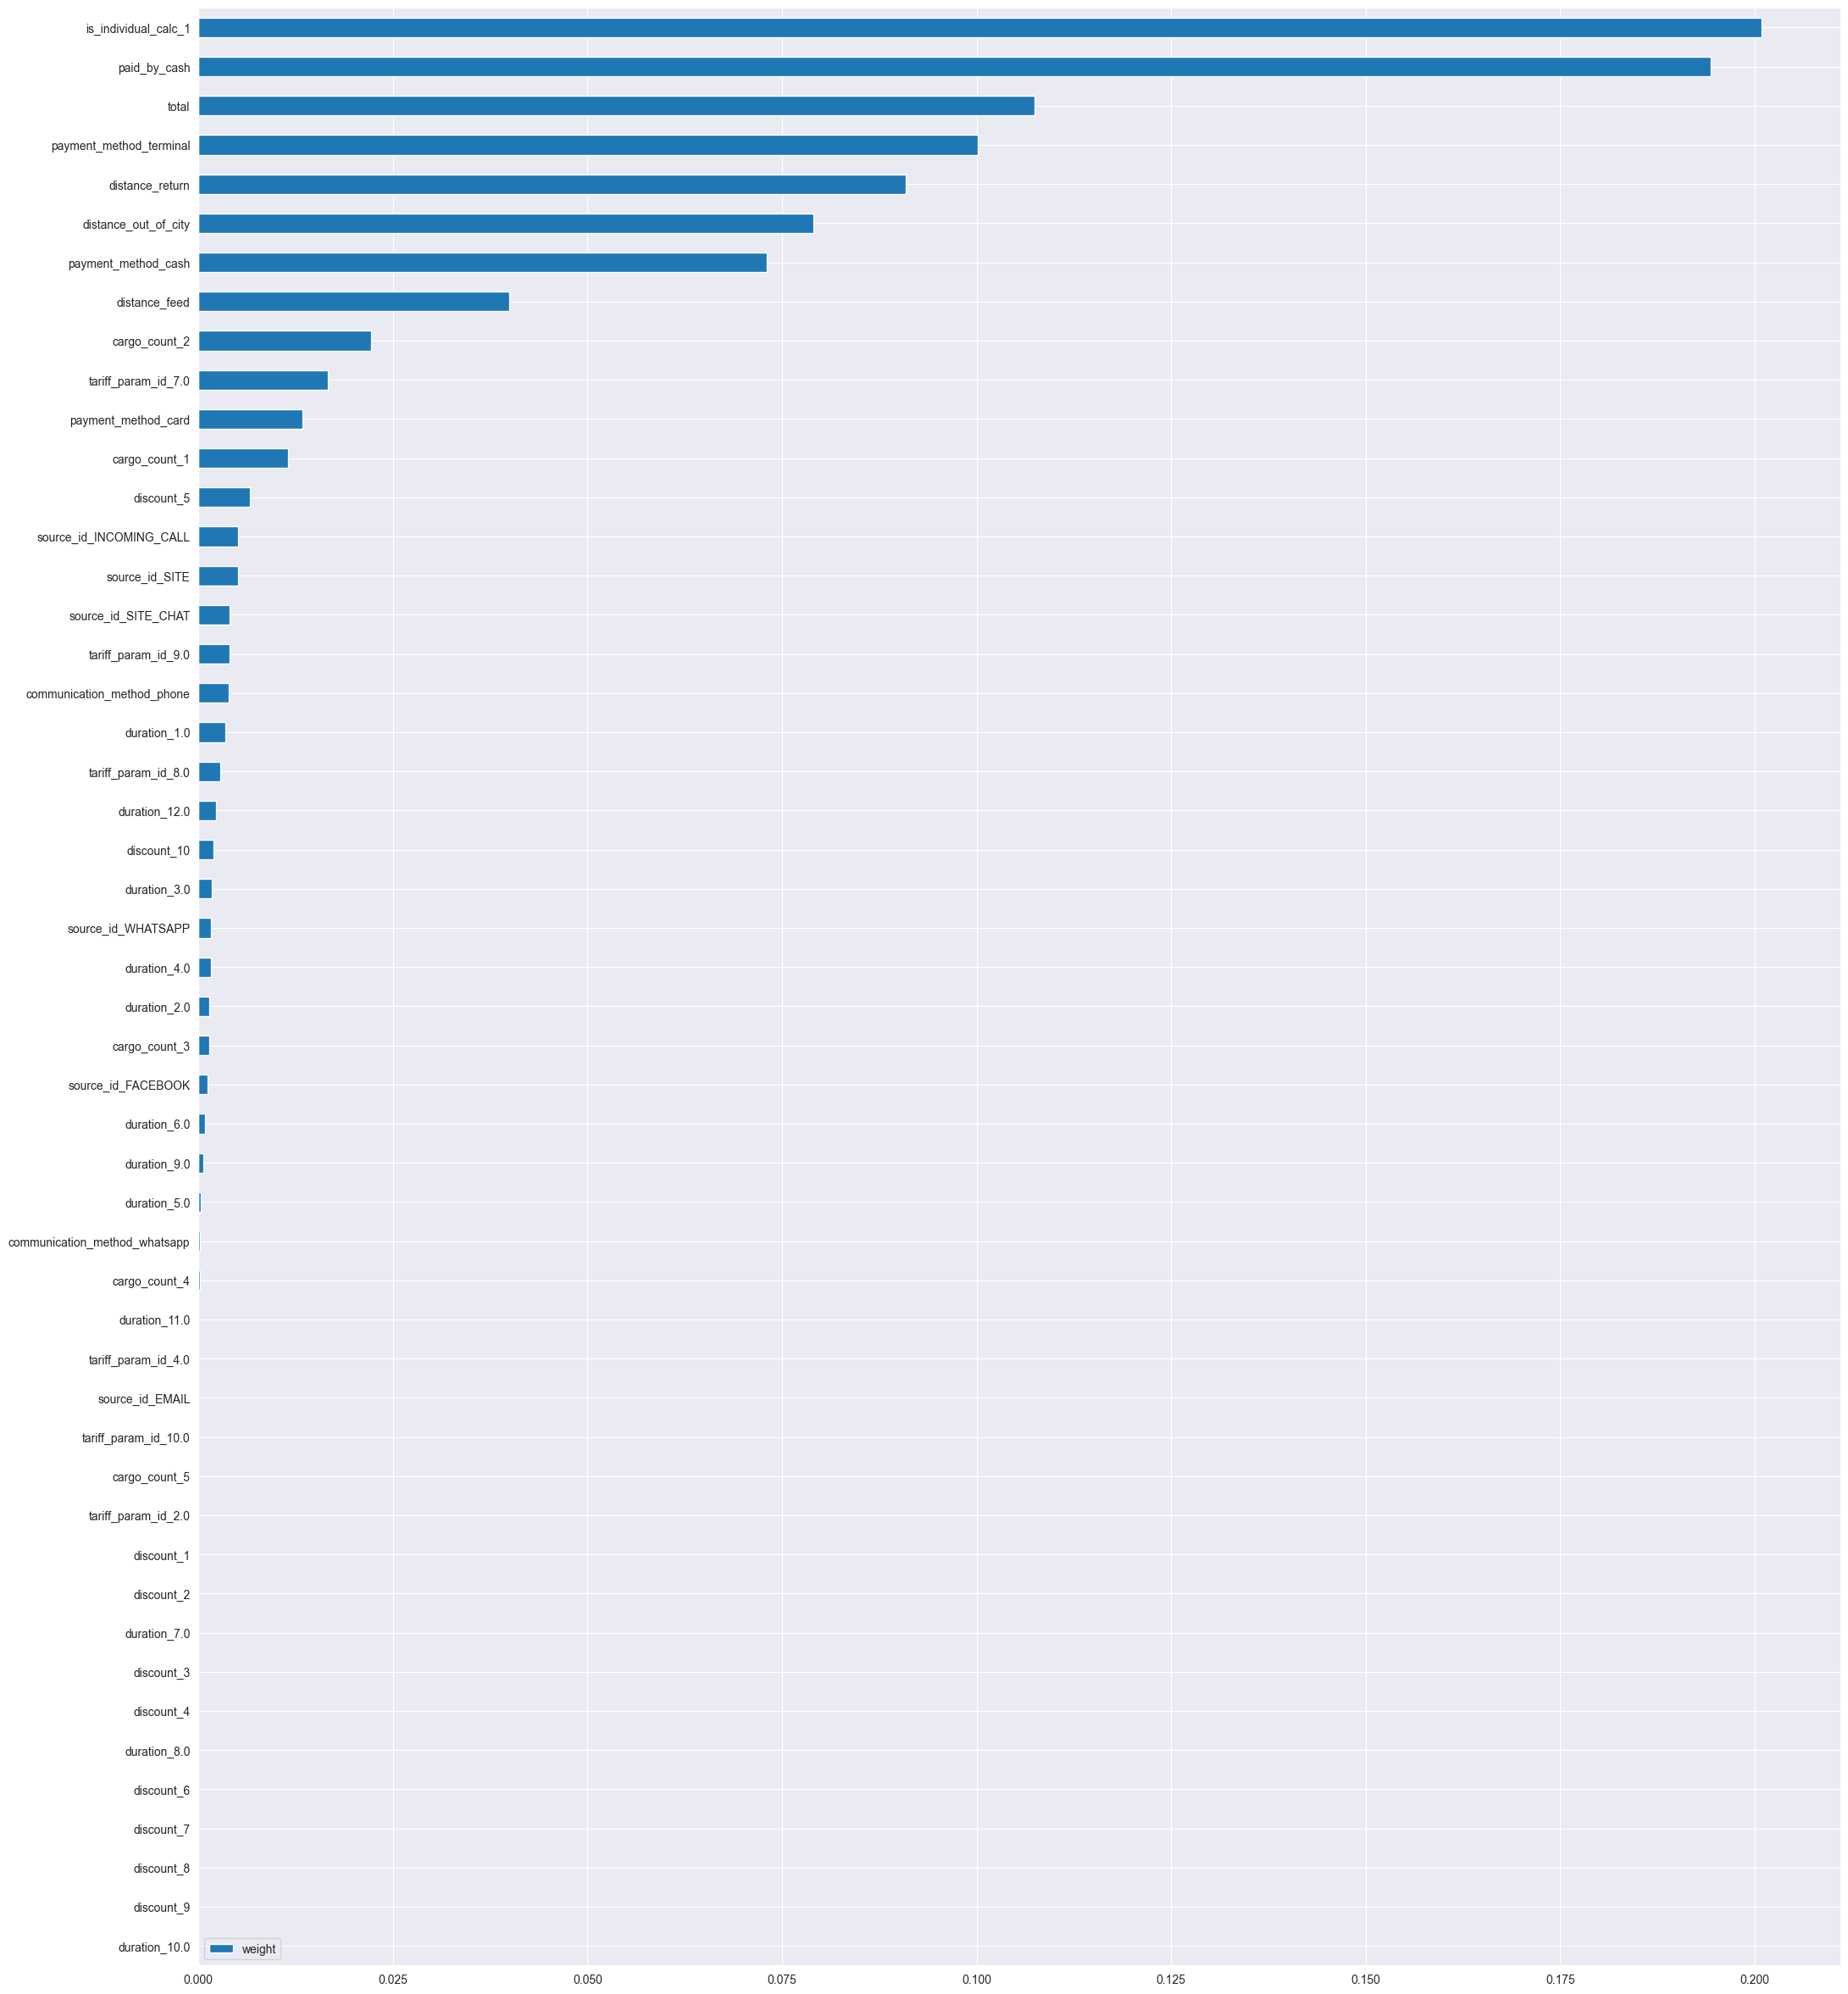

In [237]:
feature_importance.sort_values('weight').plot(kind='barh', figsize=(25, 30))
plt.show()

In [2]:
feature_importance_tree = best_clf.feature_importances_

NameError: name 'best_clf' is not defined

In [3]:
feature_importance_tree = pd.DataFrame(feature_importance_tree, index=features_names, columns=['weight'])

NameError: name 'pd' is not defined

In [1]:
feature_importance_tree.sort_values('weight').plot(kind='barh', figsize=(25, 30))
plt.show()

NameError: name 'feature_importance_tree' is not defined